# Does resizing make a difference?

A side-by-side comparison of the **FER** algorithm from the `FER` Python package pre- and post- manual resizing of images:

In [4]:
import sys
%run packages-resized.py

# Creating a Spark Session
import findspark
findspark.init("/usr/local/spark/")

from pyspark.sql import SparkSession
from pyspark.context import SparkContext

spark = SparkSession.builder \
   .master("local[8]") \
   .appName("Resizing") \
   .config("spark.executor.memory", "1gb") \
   .getOrCreate()

sc = spark.sparkContext

In [5]:
# Package imports 
import tensorflow
import pandas
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from fer import FER
import urllib.request

from pyspark.sql.functions import lit, row_number, monotonically_increasing_id, when
from pyspark.sql.window import Window

# Raw Images
import io
from io import StringIO
from io import BytesIO
from PIL import Image

---
## Random sampling

In the following chunks, we have included the code we used for randomly selecting 70 images from the whole dataset.

Please note that the code chunks are done as comments, due to the fact that we do *not* include the full dataset in the submitted zip file, which would cause an error. These chunks of code are included here purely for explanatory purposes to display how we arrived at our sample.

In [2]:
# Creating the sample and sample_small folder

#origin = './pictures/FER'
#destination = os.path.join(origin, 'sample') 
#destination_sample_small = os.path.join(origin, 'sample_small')

#if not os.path.exists(destination):
 #   os.makedirs(destination) #Creating a new folder named sample with the path = '/home/jovyan/dp2-2021w-teamkovac/pictures/FER/sample'

#if not os.path.exists(destination_sample_small):
 #   os.makedirs(destination_sample_small) #Creating a new folder named sample_small with the path = /home/jovyan/dp2-2021w-teamkovac/pictures/FER/sample_small'
    
#################
# Creating the sub-folders for each emotion label

#target_sample_small = './pictures/FER/sample_small'

#Classes = ["angry", "disgust", "fear","happy","neutral", "sad", "surprise"]

#for category in Classes:
 #   category_destination_small = os.path.join(target_sample_small, category)
  #  if not os.path.exists(category_destination_small): #Creating a new folder for each emotion category
   #     os.makedirs(category_destination_small)
    
#target = './pictures/FER/sample'

#for category in Classes:
 #   category_destination = os.path.join(target, category)
  #  if not os.path.exists(category_destination):
   #     os.makedirs(category_destination)
    
    
#################
# Random Sampling

#import shutil #for copying images from one folder to another
#import random #for random sampling

#target_small_sample = './pictures/FER/sample_small'

#for category in Classes:
    
 #   target_category = os.path.join(target, category)
 #   test_list = list()
 #   path = os.path.join("./pictures/FER/train", category)
    
 #   i = 0
 #   for i in range(10):
 #       if random.choice([x for x in os.listdir(path) if os.path.isfile(os.path.join(path, str(x)))]) not in test_list and (len(os.listdir(target_category)) != 10):
 #           test_list.append(random.choice([x for x in os.listdir(path) if os.path.isfile(os.path.join(path, str(x)))]))
 #           shutil.copyfile(os.path.join(path, str(random.choice([x for x in os.listdir(path) if os.path.isfile(os.path.join(path, str(x)))]))), os.path.join(target_category, str(random.choice([x for x in os.listdir(path) if os.path.isfile(os.path.join(path, str(x)))]))))
 #           i += 1
 #       elif random.choice([x for x in os.listdir(path) if os.path.isfile(os.path.join(path, str(x)))]) in test_list: 
 #           i -= 1 #We want unique images!
 #       elif len(os.listdir(target_category)) == 10: #We want exactly 10 images for each emotion category, so if there are already 10 images in the folder, the algorithm stops.
 #           pass
    
    
#################
# Duplicating the images   
#from distutils.dir_util import copy_tree

#for category in Classes:
 #   target_category_small = os.path.join(target_small_sample, category)
 #   path = os.path.join("./pictures/FER/sample", category)
 #   if len(os.listdir(target_category_small)) == 10:
 #       pass
 #   elif len(os.listdir(target_category_small)) == 0:
 #       copy_tree(path, target_category_small)
 #   else:
 #       shutil.rmtree(target_category_small)
 #       if not os.path.exists(target_category_small):
 #           os.makedirs(target_category_small)
 #       copy_tree(path, target_category_small)

The resizing itself using `cv2` is done and documented in `final_notebook.ipynb`. We will therefore not include it here, but already proceed with both the versions of our images.

---

Here we load the `small` and `resized` datasets with the images as binary files:

In [6]:
# Small

img_dir_train = "./FER/sample_small"
angry = spark.read.format("binaryFile").load(img_dir_train + "/angry").withColumn("label", lit("angry"))
disgust = spark.read.format("binaryFile").load(img_dir_train + "/disgust").withColumn("label", lit("disgust"))
fear = spark.read.format("binaryFile").load(img_dir_train + "/fear").withColumn("label", lit("fear"))
happy = spark.read.format("binaryFile").load(img_dir_train + "/happy").withColumn("label", lit("happy"))
neutral = spark.read.format("binaryFile").load(img_dir_train + "/neutral").withColumn("label", lit("neutral"))
sad = spark.read.format("binaryFile").load(img_dir_train + "/sad").withColumn("label", lit("sad"))
surprise = spark.read.format("binaryFile").load(img_dir_train + "/surprise").withColumn("label", lit("surprise"))

small_df = angry.union(disgust).union(fear).union(happy).union(neutral).union(sad).union(surprise) # Join them
# small_df = small_df.orderBy(rand()) # We do NOT shuffle the dataset just yet
small_df = small_df.withColumn('id', row_number().over(Window.orderBy(monotonically_increasing_id())) - 1) # Index

small_df = small_df.select("id", "path", "content", "label") # Change the columns order
# small_df.select("id", "label").show(5, truncate = False)

# Resized

img_dir_test = "./FER/sample"
angry = spark.read.format("binaryFile").load(img_dir_test + "/angry").withColumn("label", lit("angry"))
disgust = spark.read.format("binaryFile").load(img_dir_test + "/disgust").withColumn("label", lit("disgust"))
fear = spark.read.format("binaryFile").load(img_dir_test + "/fear").withColumn("label", lit("fear"))
happy = spark.read.format("binaryFile").load(img_dir_test + "/happy").withColumn("label", lit("happy"))
neutral = spark.read.format("binaryFile").load(img_dir_test + "/neutral").withColumn("label", lit("neutral"))
sad = spark.read.format("binaryFile").load(img_dir_test + "/sad").withColumn("label", lit("sad"))
surprise = spark.read.format("binaryFile").load(img_dir_test + "/surprise").withColumn("label", lit("surprise"))

resized_df = angry.union(disgust).union(fear).union(happy).union(neutral).union(sad).union(surprise) # Join them
# resized_df = resized_df.orderBy(rand()) # We do NOT shuffle!
resized_df = resized_df.withColumn('id', row_number().over(Window.orderBy(monotonically_increasing_id())) - 1) # Index

resized_df = resized_df.select("id", "path", "content", "label") # Change the columns order
resized_df.select("id", "label").show(5, truncate = False)

+---+-----+
|id |label|
+---+-----+
|0  |angry|
|1  |angry|
|2  |angry|
|3  |angry|
|4  |angry|
+---+-----+
only showing top 5 rows



---

Let's demonstrate the images:

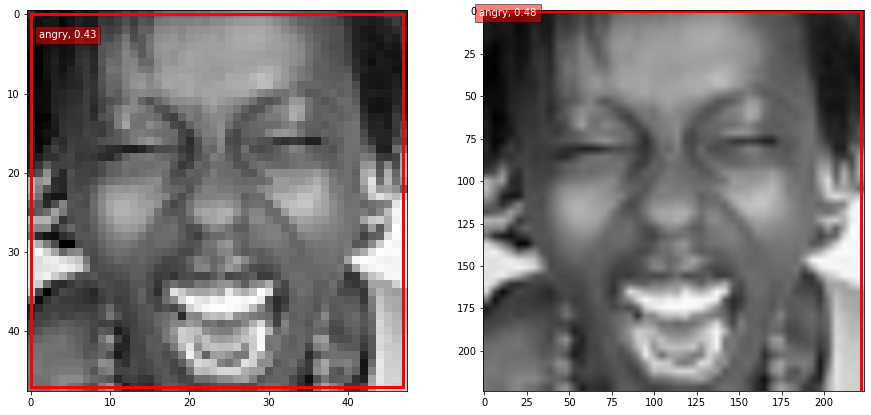

In [7]:
import matplotlib.patches as mpatches
import os
tensorflow.compat.v1.logging.set_verbosity(tensorflow.compat.v1.logging.ERROR) # Disabling tensorflow WARNING
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disabling tensorflow WARNING

plt_1 = plt.figure(figsize=(15, 10)) # Whole plot

raw1 = small_df.collect()[0]["content"] # Loading the binary file
raw2 = resized_df.collect()[0]["content"] # Loading the binary file
emo_detector = FER(mtcnn=True)

emo_colors = {"angry":"red", 
         "disgust": "brown", 
         "fear":"black", 
         "happy": "green", 
         "sad": "blue", "surprise": "yellow", 
         "neutral": "grey"} # Dictionary to assign colors to emotions

# FER 1
fer_test_image_one = np.asarray(Image.open(BytesIO(raw1)).convert('RGB'))
captured_emotions_1 = emo_detector.detect_emotions(fer_test_image_one)
dominant_emotion_1 = emo_detector.top_emotion(fer_test_image_one)

# FER 2
fer_test_image_two = np.asarray(Image.open(BytesIO(raw2)).convert('RGB'))
captured_emotions_2 = emo_detector.detect_emotions(fer_test_image_two)
dominant_emotion_2 = emo_detector.top_emotion(fer_test_image_two)

# Plot 1
plt.subplot(1, 2, 1) # First plot
plt.imshow(fer_test_image_one) # Plotting the image from path
            
loc_1 = captured_emotions_1[0]["box"] # Face Box
rect=mpatches.Rectangle((loc_1[0],loc_1[1]),loc_1[2],loc_1[3], 
                        fill = False,
                        color = emo_colors[dominant_emotion_1[0]],
                        linewidth = 3)
plt.gca().add_patch(rect) # Add the colored box into the pic
            
# Dominant Emotion:
plt.text(loc_1[0]+1, loc_1[1]+3, dominant_emotion_1[0] + ", " + str(dominant_emotion_1[1]), 
                 c="white", bbox=dict(facecolor=emo_colors[dominant_emotion_1[0]], alpha=0.5))

# Plot 2
plt.subplot(1, 2, 2) # First plot
plt.imshow(fer_test_image_two) # Plotting the image from path
            
loc_2 = captured_emotions_2[0]["box"] # Face Box
rect=mpatches.Rectangle((loc_2[0],loc_2[1]),loc_2[2],loc_2[3], 
                        fill = False,
                        color = emo_colors[dominant_emotion_2[0]],
                        linewidth = 3)
plt.gca().add_patch(rect) # Add the colored box into the pic
            
# Dominant Emotion:
plt.text(loc_2[0]+1, loc_2[1]+3, dominant_emotion_2[0] + ", " + str(dominant_emotion_2[1]), 
                 c="white", bbox=dict(facecolor=emo_colors[dominant_emotion_2[0]], alpha=0.5))

plt.show()

We see that the algorithm works better on the resized images (on the right), giving it a better estimation of where the face is along with a higher probability of the dominant emotion.

---

Now that we know the basics of our algorithm in use, let's apply it to the dataset:

In [8]:
# Dominant emotion on the picture
def emotion_binary_detection(raw):
    try:
        test_image_one = np.asarray(Image.open(BytesIO(raw)).convert('RGB'))
        emo_detector = FER(mtcnn=True)
        captured_emotions = emo_detector.detect_emotions(test_image_one)

        dominant_emotion = emo_detector.top_emotion(test_image_one)
        return dominant_emotion[0]
    except:
        return np.nan
    
# Probability score of the dominant emotion
def emotion_binary_prob(raw):
    try:
        test_image_one = np.asarray(Image.open(BytesIO(raw)).convert('RGB'))
        emo_detector = FER(mtcnn=True)
        captured_emotions = emo_detector.detect_emotions(test_image_one)

        dominant_emotion = emo_detector.top_emotion(test_image_one)
        return dominant_emotion[1]
    except:
        return np.nan

In [9]:
# Make them into spark UDFs
from pyspark.sql.functions import udf,col
from pyspark.sql.types import StringType, FloatType, IntegerType
udf_emo_binary = udf(lambda x:emotion_binary_detection(x),StringType() )
udf_prob_binary = udf(lambda x:emotion_binary_prob(x),FloatType() )

---
Predicting both datasets:

In [10]:
import time
tmp = time.time()

# Predicting the first 10 small pictures
small_predicted = small_df.withColumn("prediction", 
                     udf_emo_binary(col("content"))).withColumn("probability", 
                                                                udf_prob_binary(col("content")))
pred = small_predicted.withColumn('correct', 
                            when((col("prediction") == col("label")) , 1).otherwise(0))

tmp1 = time.time() - tmp

tmp3 = time.time()
# Predicting the first 10 resized pictures
resized_predicted = resized_df.withColumn("prediction", 
                     udf_emo_binary(col("content"))).withColumn("probability", 
                                                                udf_prob_binary(col("content")))

pred_resized = resized_predicted.withColumn('correct', 
                            when((col("prediction") == col("label")) , 1).otherwise(0))

tmp2 = time.time() - tmp3

print("The smaller pictures take around", round(tmp1,5), "seconds, while the resized ones take", round(tmp2,5),
     ". \nThere's a relative difference of", round((abs(tmp2/tmp1 - 1))*100,2), "% between the two (which, however, varies with each try).")

The smaller pictures take around 0.12673 seconds, while the resized ones take 0.06396 . 
There's a relative difference of 49.53 % between the two (which, however, varies with each try).


---

Let's see how our samples differ:

In [11]:
# Remove null values
a = pred.na.drop().count()
a2 = pred_resized.na.drop().count()
b = pred.where(pred.correct == 1).count()
b2 = pred_resized.where(pred_resized.correct == 1).count()
c = small_df.count()
d = resized_df.count()

In [12]:
print("The length of the smaller dataframe without null values is:",a)
print("The length of the resized dataframe without null values is:",a2)
print("The number of correct predictions in the smaller dataframe was:", b)
print("The number of correct predictions in the resized dataframe was:", b2)

print("\nThe smaller dataframe contains", round(((c-a)/(d-a2)),2), "times more null values than the resized one.",
     "\nAlso, the resized dataframe has a roughly", round(((b2/a2 - b/a)*100),2), 
      "% higher accuracy (Not counting null values).")

The length of the smaller dataframe without null values is: 59
The length of the resized dataframe without null values is: 58
The number of correct predictions in the smaller dataframe was: 30
The number of correct predictions in the resized dataframe was: 40

The smaller dataframe contains 0.92 times more null values than the resized one. 
Also, the resized dataframe has a roughly 18.12 % higher accuracy (Not counting null values).
